# MACHINE LEARNING HW 1
### Spencer Hann
### CS 545 | Winter 2019

## Report Part 1

In this experiment I train $3$ sets of $10$ different perceptrons on the MNIST dataset. 
Each of the perceptron sets is trained with a different learning rate, or `eta`. 
The learning rates are `0.01`, `0.1`, and `1.0`. 
Within each set, there are 10 perceptrons, each trained to recognize a specific digit 0-9.
Input data is put through each perceptron and the digit of the perceptron that most confidently classifies the digit is selected as the output of the whole model. 
I train each model (of 10 perceptrons each) for 50 epochs at each learning rate, then compare which learning rate gives the best accuracy, and look at the ways their accuracies changed during training.

## Setup

I chose to write the bulk of my code in Cython. This allowed me to use C style features to write faster code, as well as the `cython.parallel` library specifically, which allowed me to train my models using parallelism to speed up the process.

In [1]:
%load_ext Cython
import csv
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import sys
print sys.version_info
print sys.version

sys.version_info(major=2, minor=7, micro=15, releaselevel='candidate', serial=1)
2.7.15rc1 (default, Nov 12 2018, 14:31:15) 
[GCC 7.3.0]


Training and testing data is loaded, target outputs are extracted, training inputs are processed, and rows are shuffled. In lieu of keeping a separate bias vector, I add a `1` to the front of each training example vector. This will assist in faster/simpler computation.

In [3]:
training = np.genfromtxt("data/mnist_train.csv", delimiter=',')#, max_rows=1000)
testing  = np.genfromtxt("data/mnist_test.csv",  delimiter=',')#, max_rows=500)

In [4]:
np.random.shuffle(training)
np.random.shuffle(testing)

In [5]:
t_training = training[:,0].astype(np.intc) # use dtype=np.intc for compatibility w/ C layer
# training /= 255
training = np.true_divide(training, 255)
training[:,0] = 1 # adds bias(=1) column

t_testing = testing[:,0].astype(np.intc)
# testing /= 255
testing = np.true_divide(testing, 255)
testing[:,0] = 1

Initialize weights vector such that $w_{ji} \in [-0.5, 0.5]$, where $w_{ji}$ is the $i$th weight in the perceptron that predicts if an input image shows the digit $j$ $(0 \le j \le 9)$. For example, if $w_7 \cdot x > w_j$ for all $j \ne 7$, then $7$ is the prediction. More formally, $\hat y = \underset{j}{\operatorname{argmax}} w_j \cdot x$.

```python
w = np.random.rand(3,10,785) - .5 # 3 learning rates, 10 perceptrons, 785 inputs/weights
```

## Building the Model

In [6]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
#--annotate 
# the "--annotate" flag shows a copy of the cython file 
# that can be expanded to show the C it compiles 
# down to, just add the flag to the top line

#cython: boundscheck=False, wraparound=False
# ^^ prevents automatic checking for out of bounds indices 
# for arrays and negative indices for wraparounds

import cython
import sys
import numpy as np
cimport numpy as np
import time
from cython.parallel cimport prange


######################################################
##              MATH/UTILITY FUNCTIONS              ##
######################################################

# returns index of largest element in array
cdef int cargmax(double[10] array) nogil:
    cdef int max = 0
    cdef Py_ssize_t i
    
    for i in range(1,10):
        if max < array[i]:
            max = i
    return max

# dot product function capable of being called without
# Python's Global Interpreter Lock (gil)
cdef double dot(double[::1] w, double[::1] x) nogil:
    cdef double dp = 0.0
    cdef Py_ssize_t i
    
    for i in prange(785):
        dp += w[i] * x[i]
        
    return dp


######################################################
##                 ACCURACY TESTING                 ##
######################################################

# determine digit based on testing/training example
def predict(w,x):
    cdef double[10] results # C array
    cdef Py_ssize_t j
    
    for j in range(10):
        results[j] = dot(w[j],x)
        
    return cargmax(results)

# very similar to predict, but target is given and correctness is checked
cdef int check(double[:,::1] w, int t, double[::1] x) nogil:
    cdef double[10] results # C array
    cdef Py_ssize_t j
    
    for j in prange(10):
        results[j] = dot(w[j],x)
        
    return cargmax(results) == t

# returns number of correct classifications over number of examples
cdef double test_accuracy(double[:,::1] w, int[::1] T, double[:,::1] X):
    cdef int n = T.shape[0]
    cdef Py_ssize_t i
    cdef int num_correct = 0
    cdef str n_str = str(n)

    for i in prange(n, nogil=True):
        num_correct += check(w,T[i],X[i])

    return num_correct / np.float(n)


#######################################################
##                    TRAINING                       ##
#######################################################

# trains all 10 perceptrons in parallel on a single training example
cdef void training_example(double[:,::1] w, int t, double[::1] x, double lrning_rate) nogil:
    cdef int y
    cdef Py_ssize_t i, j
    cdef double delta_w
    
    for j in prange(10):#, nogil=True):
        y = 1 if dot(w[j],x) > 0 else 0
        # 't' step re-worked for efficiency -- 
        # t = 1 or 0, then y is subtracted and 
        # result is multiplied by learning rate in-line
        # prior to loop to save time
        delta_w = lrning_rate*(1-y) if j == t else lrning_rate*(0-y)
        if not delta_w: 
            continue
        for i in prange(785):
            w[j,i] += delta_w * x[i]

# trains all 10 perceptrons on all training examples in parallel
cdef double train_epoch(double[:,::1] w, int[::1] T, double[:,::1] X, double eta):
    cdef int i, n = T.shape[0]
    
    for i in prange(n, nogil=True):
        training_example(w, T[i], X[i],eta)
    return test_accuracy(w,T,X)

# main training function, runs through all learning rates
def train(
    double[:,:,::1] w, 
    int[::1] T_train, int[::1] T_test, 
    double[:,::1] X_train, double[:,::1] X_test,
    double[:,::1] training_accuracies,
    double[:,::1] testing_accuracies, 
    int n=50, np.float eta=1.0
):
    # max_test tracks the accuracy peaks for each learning rate
    cdef np.ndarray max_test = np.zeros(3, dtype=np.float)
    cdef Py_ssize_t i

    for i in range(3):
        # epoch 0 accuracies
        training_accuracies[i,0] = test_accuracy(w[i],T_train,X_train)
        testing_accuracies[i,0] = test_accuracy(w[i],T_test,X_test)
        
        # training phase n epochs
        for j in range(1,n):
            training_accuracies[i,j] = train_epoch(w[i],T_train,X_train,eta)
            testing_accuracies[i,j] = test_accuracy(w[i],T_test,X_test)
            
            # check if epoch accuracy is a new best
            if testing_accuracies[i,j] > max_test[i]:
                max_test[i] = testing_accuracies[i,j]
                
        print("{f} accuracy : ".format(f=eta),
              training_accuracies[i,n-1],
              testing_accuracies[i,n-1])
        print(time.ctime()) # keeps me updated during training
        eta /= 10

    return max_test

## Training

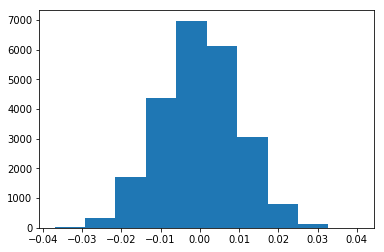

Sun Jan 20 19:00:58 2019
('1.0 accuracy : ', 0.8143, 0.8057)
Sun Jan 20 19:01:45 2019
('0.1 accuracy : ', 0.8195, 0.8117)
Sun Jan 20 19:02:31 2019
('0.01 accuracy : ', 0.8105666666666667, 0.8095)
Sun Jan 20 19:03:16 2019
CPU times: user 6min 13s, sys: 2min 53s, total: 9min 6s
Wall time: 2min 18s
('Max:', array([0.8248, 0.8461, 0.8468]))


In [27]:
n = 51 # number of epochs per learning rate

# re-init each time I run this cell
w = np.random.randn(3,10,785) * 0.01
plt.hist(w.flatten())
plt.show()
w[1] = np.random.rand(10,785) - .5
w[:,:,0] = 1

# This is an experiment to see what happens if I initialize
# all thre models start with identical weights matrices
# w = np.empty((3,10,785), dtype=np.float)
# w[:] = np.random.rand(10,785) - .5

# matrices for tracking accuracy
epoch_training = np.empty((3,n), dtype=np.float)
epoch_testing = np.empty((3,n), dtype=np.float)

print(time.ctime())  # reminds me when training began
                     # optimized version takes about 2 1/2 min
sys.stdout.flush() # forces output, so I don't have to wait for `print()`
%time max_accr = train(w, t_training, t_testing, training, testing, epoch_training, epoch_testing, n=n)
print("Max:",max_accr)

## Report part 2
### Analysis by Learning Rate

In [8]:
# %matplotlib notebook
def accuracy_plot(i):
    print("Learning Rate #%d \nFinal Accuracy: %.1f%% \nMax Accuracy:   %.1f%%" % \
          (i+1, 100 * epoch_testing[i,-1], 100 * max_accr[i]))

    plt.plot(epoch_training[i],    label="Training" + str(i))
    plt.plot(epoch_testing[i],     label="Testing" + str(i))

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.legend()    
    plt.grid()

    plt.show()

In [9]:
def create_conf_matrix(w, T, X):
    N = T.shape[0]
    results = np.zeros((3,11,11), dtype=np.intc)

    for l in range(3):
        for n in range(N):
            i = T[n]
            j = predict(w[l],X[n])
            results[l,i,j] += 1
            results[l,i,10] += 1
            results[l,10,j] += 1

    return results

In [10]:
def display_conf_matrix(conf_matrix):
    _,ax = plt.subplots(figsize=(10,10))
    ax.set_title("Confusion Matrix")

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            if i == 10 and j == 10: break
            num = conf_matrix[i,j]
            ax.text(i, j, str(num), va="center", ha="center")
            
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    ax.matshow(conf_matrix[:10,:10], cmap=plt.cm.Wistia)


### Learning Rate = 1.0

Learning Rate #1 
Final Accuracy: 80.1% 
Max Accuracy:   82.4%


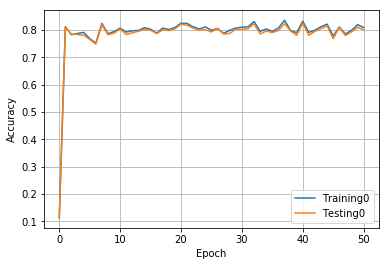

In [20]:
accuracy_plot(0)

This graph shows the training and testing accuracy of the first model (learning rate = 1) over time. This was the least successful model. That was not the case every time, however. The model usually performed similarly well. That being said it does seem to generalize well to the testing data, so I don't think there was any overfitting. There is definitely a lot of oscillation. The accuracy jumps to 80% after epoch one and then barely improves over the next 49 epocs.

In [21]:
# conf_matrix = create_conf_matrix(w, t_testing, testing)
# display_conf_matrix(conf_matrix[0])

The mistakes made by this model seem somewhat spread out. One thing that stands out to me is the very first row. High numbers along the whole `0` row, imply that this model was very likely to misclassify `0` in general, and especially as an `8`. This is in contrast two the second row, where we can see that the model very rarely incorrectly classifies a `1` as something else. Interestingly, this model was likely to classify a `5` as a `3` (181 times), but much less likely to make the opposite mistake (only 8 times).

### Learning Rate = 0.1

Learning Rate #2 
Final Accuracy: 83.4% 
Max Accuracy:   84.5%


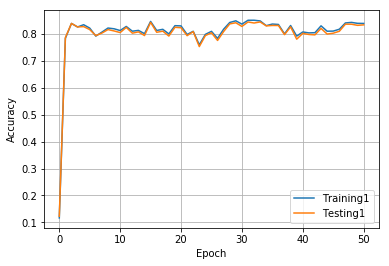

In [22]:
accuracy_plot(1)

Similar to the graph before, the training accuracies align almost perfectly with the testing accuracies, which leads me to believe that overfitting is not an issue here. Also similar to the first graph, this shows a jump to about 80% after the very first epoch and then oscillation for the next 49. Just by looking at the graph it appears the testing accuracy peak may have even been at epoch two.

In [23]:
# display_conf_matrix(conf_matrix[1])

Similar to the previous model, this model frequently mistakes `0` for other digits, especially `8`, but is relative accuratey with classifying `1`. This model also seems to miss `5`s a lot.

### Learning Rate = 0.01

Learning Rate #3 
Final Accuracy: 80.4% 
Max Accuracy:   85.1%


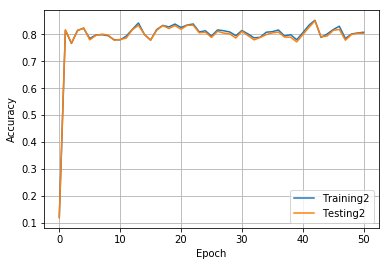

In [24]:
accuracy_plot(2)

This graph doesn't show anything too different from the first two. There doesn't seem to be any overfitting. It is mostly just oscillation after epoch 1 or 2.

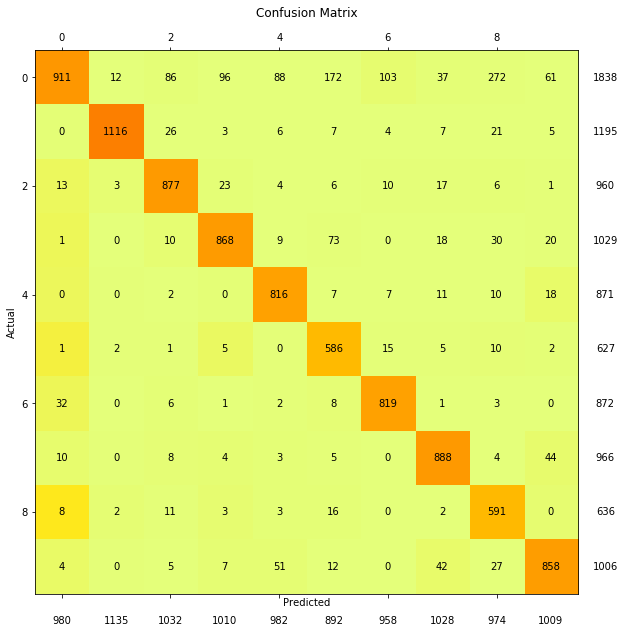

In [16]:
display_conf_matrix(conf_matrix[2])

This model seems to have done better that the other two overall, but has an even worse accuracy with `0` than the other two.

## Report Part 3
### Learning Rate Comparison
At times it seemed that the greater learning rate of `1.0` would perform more poorly than the other two, but this was not always the case, and I did not do any kind of analysis to see if this was statistically significant.
What I did think was interesting, however, was the rate of improvement in accuracy for all the learning rates.
They all sky rocket on just the first epoch, and I rarely saw significant improvement after the first few epochs.
It would be interesting to experiment with my smaller learning rates to slow the learning down slightly. Perhaps this could improve accuracy.